first define helper functions to create vertical and horizonal coordinate grids in a predefined box

In [1]:
import numpy as np
import pandas as pd
import math

def get_lat_to_londiff_map(box=None):
    if box is None:
        box = [-87.5, 87.5, -180, 180]
    lat_low, lat_high, lon_low, lon_high = box

    # mean earth radius in km - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius
    earth_radius = 6371.0088
    lat_low, lat_high, lon_low, lon_high = box
    lat_grid = np.arange(lat_low, lat_high, 0.05)
    # for every latitude scale the circle on the earths surface parallel to the equator.
    scaled_rads = np.cos(lat_grid / 360.0 * (2*math.pi)) * earth_radius
    # for every fixed latitude calculate the length in longitudes of 5 kms
    kms_in_lons = (5. / scaled_rads) / (2*math.pi) * 360

    map_df = pd.DataFrame(np.array([lat_grid, kms_in_lons]).T, columns=['lat', 'lon_step'])
    # convert lat to int for easier indexing
    #map_df['lat'] = np.round((map_df['lat'] * 100), 0).astype(int)
    map_df.set_index('lat', inplace=True)
    return map_df

def get_horizontal_box(map_df, box=None, with_random_offsets=True):
    if box is None: # box spans entire globe
        box = [-90, 90, -180, 180]
    lat_low, lat_high, lon_low, lon_high = box
    
    if with_random_offsets:
        offsets = np.random.uniform(0, 20, len(map_df))
    else:
        offsets = 0
    map_df['offsets'] = offsets

    def get_lons(row):
        offset = row['offsets'] * 0.1 # scale the offset a bit (does it make sense?)
        step = row['lon_step']
        lons = np.arange(lon_low + offset, lon_high, step)
        lons = np.floor(lons * 20) / 20.0 # round to 0.05 degree
        lons = np.unique(lons)
        return pd.DataFrame({
            'lat': row.name,
            'lon': lons
        })
    
    df_hbox =pd.concat(map_df.loc[lat_low:lat_high].apply(get_lons, axis=1).tolist(), axis=0, ignore_index=True)
    return df_hbox

def get_reference_vertical_box(box=None):
    if box is None: # box spans entire globe
        box = [-90, 90, -180, 180]
    lat_low, lat_high, lon_low, lon_high = box

    lons = np.arange(lon_low, lon_high, 0.05)
    lats = np.arange(lat_low, lat_high, 0.05)
    
    lats = np.floor(lats * 20) / 20.0 # round to 0.05 degree
    lons = np.floor(lons * 20) / 20.0 # round to 0.05 degree

    coords = np.meshgrid(lats, lons)
    df_fixed_vbox = pd.DataFrame({
        'lat': coords[0].flatten(),
        'lon': coords[1].flatten()
    })
    return df_fixed_vbox

def get_vertical_box(map_df, box=None, with_random_offsets=True):
    if box is None: # box spans entire globe
        box = [-90, 90, -180, 180]
    lat_low, lat_high, lon_low, lon_high = box

    lons = np.arange(lon_low, lon_high, 0.05)
    lats = np.arange(lat_low, lat_high, 0.05)
    
    if with_random_offsets:
        lat_offsets = np.random.uniform(0, 1, len(lats)) * 0.1
        lon_offsets = np.random.uniform(0, 1, len(lons)) * 0.1
    else:
        lat_offsets = 0
        lon_offsets = 0
    
    lats = np.floor((lats + lat_offsets) * 20) / 20.0 # round to 0.05 degree
    lons = np.floor((lons + lon_offsets) * 20) / 20.0 # round to 0.05 degree

    # clip to the box
    lats = np.clip(lats, lat_low-0.05, lat_high-0.05)
    lons = np.clip(lons, lon_low-0.05, lon_high-0.05)


    coords = np.meshgrid(lats, lons)
    df_vbox = pd.DataFrame({
        'lat': coords[0].flatten(),
        'lon': coords[1].flatten()
    })
    return df_vbox

from fco2dataset.ucollocate import get_day_data, collocate
def get_day_dataset(date):
    # get global satellite data for a given date
    dss = get_day_data(date, save_path='../data/inference/gridded')
    return dss

def collocate_coords(df, dss, date):
    save_path = '../data/inference/collocated'
    df_collocated = collocate(df, date, save_path=save_path, dss=dss, verbose=False)
    return df_collocated

def add_xco2(df, xco2_mbl):
    selector = df[['lat', 'time']].to_xarray()
    matched_xco2 = xco2_mbl.sel(**selector, method='nearest').to_series()
    df['xco2'] = matched_xco2
    return df 

def add_clims(df, co2_clim):
    selector = df[['lat', 'lon', 'day_of_year']].to_xarray()
    selector = selector.rename({'day_of_year': 'dayofyear'})
    #url = 'https://data.up.ethz.ch/shared/.gridded_2d_ocean_data_for_ML/co2_clim/prior_dfco2-lgbm-ens_avg-t46y720x1440.zarr/'
    df['co2_clim8d'] = co2_clim.dfco2_clim_smooth.sel(**selector, method='nearest')
    return df

def get_context_data(df, predictors, orientation, num_windows=64):
    # always add lat/lon to the context data
    predictors = predictors + ['lat', 'lon']
    
    def get_context(coord1_df):
        tot_windows = coord1_df.shape[0] 
        num_segments = tot_windows // num_windows + 1
        ds = np.zeros((num_segments, len(predictors), num_windows), dtype=np.float32)
        for i in range(num_segments - 1):
            start = i * num_windows
            end = (i + 1) * num_windows
            ds[i] = coord1_df[predictors].iloc[start:end].values.T
        # last segment
        end = tot_windows
        start = tot_windows - num_windows
        ds[-1] = coord1_df[predictors].iloc[start:end].values.T
        return ds
    
    # get context data for each coordinate
    coord1 = 'lat' if orientation == 'horizontal' else 'lon'
    ds = df.groupby(coord1)[predictors].apply(get_context)
    ds = np.concatenate(ds.values, axis=0)
    return ds

def normalize(df, stats, mode):
    for i in range(1, len(stats['means'])): # first column is the target
        col = df.columns[i - 1]
        # print(f"Normalizing {col} with {mode}")
        if mode == 'min_max':
            # print(f"Min: {stats['mins'][i]}, Max: {stats['maxs'][i]}")
            df[col] = 2 * (df[col] - stats['mins'][i]) / (stats['maxs'][i] - stats['mins'][i]) - 1
        elif mode == 'mean_std':
            df[col] = (df[col] - stats['means'][i]) / stats['stds'][i]
        else:
            raise ValueError(f"Unknown mode {mode}")
    return df

def get_sample_df(box):
    sample_lats = np.arange(box[0], box[1], 0.05)
    sample_lons = np.arange(box[2], box[3], 0.05)
    # move lons to -180 to 180
    sample_lons = (sample_lons + 180) % 360 - 180
    sample_data = np.random.rand(sample_lats.shape[0], sample_lons.shape[0])


    # convert to coordiates to int for easier indexing
    sample_lats = np.round(sample_lats * 100, 0).astype(int)
    sample_lons = np.round(sample_lons * 100, 0).astype(int)
    df_sample = pd.DataFrame(
        sample_data.flatten(), 
        index=pd.MultiIndex.from_product([sample_lats, sample_lons], names=['lat', 'lon']),
        columns=['sample']
    )
    return df_sample
    

In [2]:
box = [-10, 10, -20, 20]
map_df = get_lat_to_londiff_map()
map_df.head()

,lon_step
lat,
-87.50,1.030872
-87.45,1.010672
-87.40,0.991249
-87.35,0.972559
-87.30,0.954562


In [3]:

hbox = get_horizontal_box(map_df.copy(), box=box)
hbox.head()

,lat,lon
0,-9.95,-19.45
1,-9.95,-19.40
2,-9.95,-19.35
3,-9.95,-19.30
4,-9.95,-19.25


In [4]:
hbox.shape

(312905, 2)

In [5]:
vbox = get_vertical_box(map_df.copy(), box=box)

In [6]:
vbox

,lat,lon
0,-9.95,-19.95
1,-9.90,-19.95
2,-9.85,-19.95
3,-9.85,-19.95
4,-9.80,-19.95
...,...,...
319995,9.80,19.95
319996,9.85,19.95
319997,9.90,19.95
319998,9.90,19.95


In [7]:
date = pd.Timestamp('2022-10-04')
dss = get_day_dataset(date)

All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.nc


In [8]:
dss.keys()

dict_keys(['globcolour', 'soda', 'cmems', 'sss_cci', 'sss_multiobs', 'sst_cci'])

In [9]:
dss['globcolour']

<xarray.Dataset> Size: 336MB
Dimensions:                (time: 1, lat: 4320, lon: 8640)
Coordinates:
  * time                   (time) datetime64[ns] 8B 2022-10-04
  * lat                    (lat) float32 17kB 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                    (lon) float32 35kB 0.02084 0.06251 ... 359.9 360.0
Data variables:
    chl_globcolour         (time, lat, lon) float32 149MB dask.array<chunksize=(1, 256, 254), meta=np.ndarray>
    chl_globcolour_uncert  (time, lat, lon) float32 149MB dask.array<chunksize=(1, 256, 254), meta=np.ndarray>
    chl_globcolour_flags   (time, lat, lon) int8 37MB dask.array<chunksize=(1, 256, 254), meta=np.ndarray>
Attributes: (12/91)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    contact:                         servicedesk.cmems@acri-st.fr
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-11-08T22:12:38Z
    nb_valid_bins:                   19901268
    pct_valid_bins:                  53.319155092592595

In [10]:
vbox_collocated = collocate_coords(vbox, dss, date=date)
hbox_collocated = collocate_coords(hbox, dss, date=date)

In [11]:
vbox_collocated.head()

,index,lat,lon,time,chl_globcolour,chl_globcolour_uncert,chl_globcolour_flags,time_globcolour,lat_globcolour,lon_globcolour,...,lat_sss_multiobs,lon_sss_multiobs,depth_sss_multiobs,time_sss_multiobs,sst_cci,sst_cci_uncertainty,ice_cci,time_sst_cci,lat_sst_cci,lon_sst_cci
0,0,-9.95,-19.95,2022-10-04,0.152147,36.049999,2,2022-10-04,-9.937503,0.020839,...,-9.9375,0.0625,0.0,2022-10-04,295.559998,0.20,0.0,2022-10-05,-9.925,0.025
1,1,-9.90,-19.95,2022-10-04,0.150965,36.090000,2,2022-10-04,-9.895836,0.020839,...,-9.9375,0.0625,0.0,2022-10-04,295.609985,0.21,0.0,2022-10-05,-9.875,0.025
2,2,-9.85,-19.95,2022-10-04,0.153575,41.000000,2,2022-10-04,-9.854170,0.020839,...,-9.8125,0.0625,0.0,2022-10-04,295.609985,0.21,0.0,2022-10-05,-9.875,0.025
3,3,-9.85,-19.95,2022-10-04,0.153575,41.000000,2,2022-10-04,-9.854170,0.020839,...,-9.8125,0.0625,0.0,2022-10-04,295.609985,0.21,0.0,2022-10-05,-9.875,0.025
4,4,-9.80,-19.95,2022-10-04,0.152545,41.029999,2,2022-10-04,-9.812503,0.020839,...,-9.8125,0.0625,0.0,2022-10-04,295.669983,0.20,0.0,2022-10-05,-9.825,0.025


In [12]:
predictors = ['sst_cci', 'sss_cci', 'chl_globcolour']
vbox_collocated[predictors].describe()

,sst_cci,sss_cci,chl_globcolour
count,192583.000000,177701.000000,198984.000000
mean,298.278107,35.367058,0.741981
std,1.408648,0.841085,2.473097
min,294.850006,25.088772,0.074056
25%,297.000000,35.206787,0.138744
50%,298.859985,35.496014,0.174315
75%,299.419983,35.810596,0.237460
max,301.399994,36.586830,52.044060


In [13]:
vds = get_context_data(vbox_collocated, predictors, orientation='vertical', num_windows=64)
hds = get_context_data(hbox_collocated, predictors, orientation='horizontal', num_windows=64)

In [14]:
vds.shape, hds.shape

((5390, 5, 64), (5149, 5, 64))

In [15]:
vds[700, :, 0]

array([ 2.996600e+02,  3.508562e+01,  9.169479e-02,  2.050000e+00,
       -1.485000e+01], dtype=float32)

In [16]:
import xarray as xr
def get_sample(box):
    sample_lats = np.arange(box[0], box[1], 0.05)
    sample_lons = np.arange(box[2], box[3], 0.05)
    sample_data = np.random.rand(sample_lats.shape[0], sample_lons.shape[0])
    
    xr_sample = xr.DataArray(
        sample_data, 
        dims=['lat', 'lon'], 
        coords=[sample_lats, sample_lons], 
        name='sample'
    )
    return xr_sample



In [17]:
import torch
import torch.nn as nn
from tqdm import tqdm
from fco2models.utraining import prep_df


def denoise2d(model, noise_scheduler, params, stats, date, jump=20, box=None):
    """full denoising loop for a 2d image for diffusion model"""
    if box is None:
        box = [-90, 90, -180, 180]
    
    predictors = params['predictors']
    mode = params['mode']
    map_df = get_lat_to_londiff_map(box=box)
    dss = get_day_dataset(date)
    sample_df = get_sample_df(box=box)

    df_fixed_vbox = get_reference_vertical_box(box=box)
    fixed_vbox_collocated = collocate_coords(df_fixed_vbox, dss, date=date)
    fixed_vbox_collocated['time_1d'] = date
    fixed_vbox_collocated['lon'] = (fixed_vbox_collocated['lon'] + 180) % 360 - 180
    fixed_vbox_collocated = prep_df(fixed_vbox_collocated, with_target=False, with_log=False)[0]
    fixed_vbox_collocated = fixed_vbox_collocated[predictors + ['lat', 'lon']]
    fixed_vbox_collocated = normalize(fixed_vbox_collocated, stats, mode)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")
    model.to(device)
    step = 0
    t_loop = tqdm(noise_scheduler.timesteps[::jump], desc="Denoising steps")
    for t in t_loop:
        
        if step % 2 == 0:
            hbox = get_horizontal_box(map_df.copy(), box=box)
            hbox_collocated = collocate_coords(hbox, dss, date=date)
            # hbox_collocated = add_features(hbox_collocated, date, predictors)
            hbox_collocated['time_1d'] = date
            # move lons to -180, 180
            hbox_collocated['lon'] = (hbox_collocated['lon'] + 180) % 360 - 180
            hbox_collocated = prep_df(hbox_collocated, with_target=False, with_log=False)[0]
            hbox_collocated = hbox_collocated[predictors + ['lat', 'lon']]
            hbox_collocated = normalize(hbox_collocated, stats, mode)
            ds = get_context_data(hbox_collocated, predictors, orientation='horizontal', num_windows=64)
        else:
            # vbox = get_vertical_box(map_df.copy(), box=box)
            # vbox_collocated = fixed_vbox_collocated[]
            # vbox_collocated = collocate_coords(vbox, dss, date=date)
            # # vbox_collocated = add_features(vbox_collocated, date, predictors)
            # vbox_collocated['time_1d'] = date
            # # move lons to -180, 180
            # vbox_collocated['lon'] = (vbox_collocated['lon'] + 180) % 360 - 180
            # vbox_collocated = prep_df(vbox_collocated, with_target=False, with_log=False)[0]
            # vbox_collocated = vbox_collocated[predictors + ['lat', 'lon']]
            # vbox_collocated = normalize(vbox_collocated, stats, mode)
            ds = get_context_data(fixed_vbox_collocated, predictors, orientation='vertical', num_windows=64)

        #print("got context data")
        lats = np.round(ds[:, -2, :] * 100, 0).astype(int)
        lons = np.round(ds[:, -1, :] * 100, 0).astype(int)
        # sample_array = xr.apply_ufunc(
        #     lambda lat, lon: sample_df.sel(lat=lat, lon=lon, method='nearest', tolerance=0.0001),
        #     xr.DataArray(lats), xr.DataArray(lons),
        #     vectorize=True,
        #     ).values
        # lats = sample_array.lat.values
        # lons = sample_array.lon.values
        # sample_array = sample_array.values
        # print(lats[:10])
        sample_array = sample_df.loc[zip(lats.flatten(), lons.flatten())].values
        #print("collocated sample data")
        #sample_array = sample_df.loc[zip(lats.flatten(), lons.flatten())].values
        n_samples, _, n_bins = ds.shape
        sample_array = sample_array.reshape(n_samples, 1, n_bins)
        
        ds = ds[:, :-2, :] # remove lat/lon from the context data
        ds = np.concatenate([sample_array, ds, np.ones_like(sample_array)], axis=1)
        # count nans percentage in the sample array
        ds = torch.from_numpy(ds).to(device).float()
        dataloader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=False)
        samples = []
        for (ix, batch) in enumerate(dataloader):
            with torch.no_grad():
                batch = batch.to(device)
                #context = batch[:, 1:, :].to(device)
                sample = batch[:, 0:1, :].to(device)
                noise_pred = model(batch, t, return_dict=False)[0]
                x_0 = noise_scheduler.step(noise_pred, t, sample).pred_original_sample
                if t - jump > 0:
                    sample = noise_scheduler.add_noise(x_0, torch.randn_like(sample), t - jump)
                else:
                    sample = x_0
                samples.append(sample.cpu().numpy())
            t_loop.set_postfix({"batch":{ix}})
        
        samples = np.concatenate(samples, axis=0).flatten()
        mask = ~np.isnan(samples)
        sample_df.loc[zip(lats.flatten()[mask], lons.flatten()[mask]), 'sample'] = samples[mask]
        step += 1
    return sample_df


In [18]:
from fco2models.models import UNet2DModelWrapper, UNet1DModel
from fco2models.ueval import load_model
import torch
# load baseline model
save_path = '../models/renko/co2clim/naive_pos/'
model_path = 'e_60.pt'
model_class = UNet2DModelWrapper
model, noise_scheduler, params, losses = load_model(save_path, model_path, model_class)
print("Baseline model loaded")

Baseline model loaded


In [19]:
params['predictors']

['sst_cci',
 'sss_cci',
 'chl_globcolour',
 'ssh_sla',
 'mld_dens_soda',
 'xco2',
 'co2_clim8d',
 'sin_day_of_year',
 'cos_day_of_year',
 'sin_lat',
 'sin_lon_cos_lat',
 'cos_lon_cos_lat']

In [20]:
# import model and noise scheduler
from fco2models.models import UNet2DModelWrapper
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
box = [-10, 10, 250, 280]
date = pd.Timestamp('2022-10-04')
stats = {
    'means':params['train_means'],
    'stds':params['train_stds'],
    'mins':params['train_mins'],
    'maxs':params['train_maxs']
}
sample_df=denoise2d(model, noise_scheduler, params, stats=stats, date=date, box=box, jump=20)

All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.nc
Training on cuda


Denoising steps: 100%|██████████| 50/50 [07:36<00:00,  9.12s/it, batch={65}]


In [21]:
sample_df = sample_df.reset_index()
sample_df['lat'] = sample_df['lat'] /100
sample_df['lon'] = sample_df['lon'] /100
sample_df.set_index(['lat', 'lon'], inplace=True)
sample_ds = sample_df.to_xarray()

In [22]:
sample_ds

<xarray.Dataset> Size: 2MB
Dimensions:  (lat: 400, lon: 600)
Coordinates:
  * lat      (lat) float64 3kB -10.0 -9.95 -9.9 -9.85 -9.8 ... 9.8 9.85 9.9 9.95
  * lon      (lon) float64 5kB -110.0 -110.0 -109.9 ... -80.15 -80.1 -80.05
Data variables:
    sample   (lat, lon) float64 2MB -0.1082 -0.03594 -0.03454 ... 0.2621 0.536

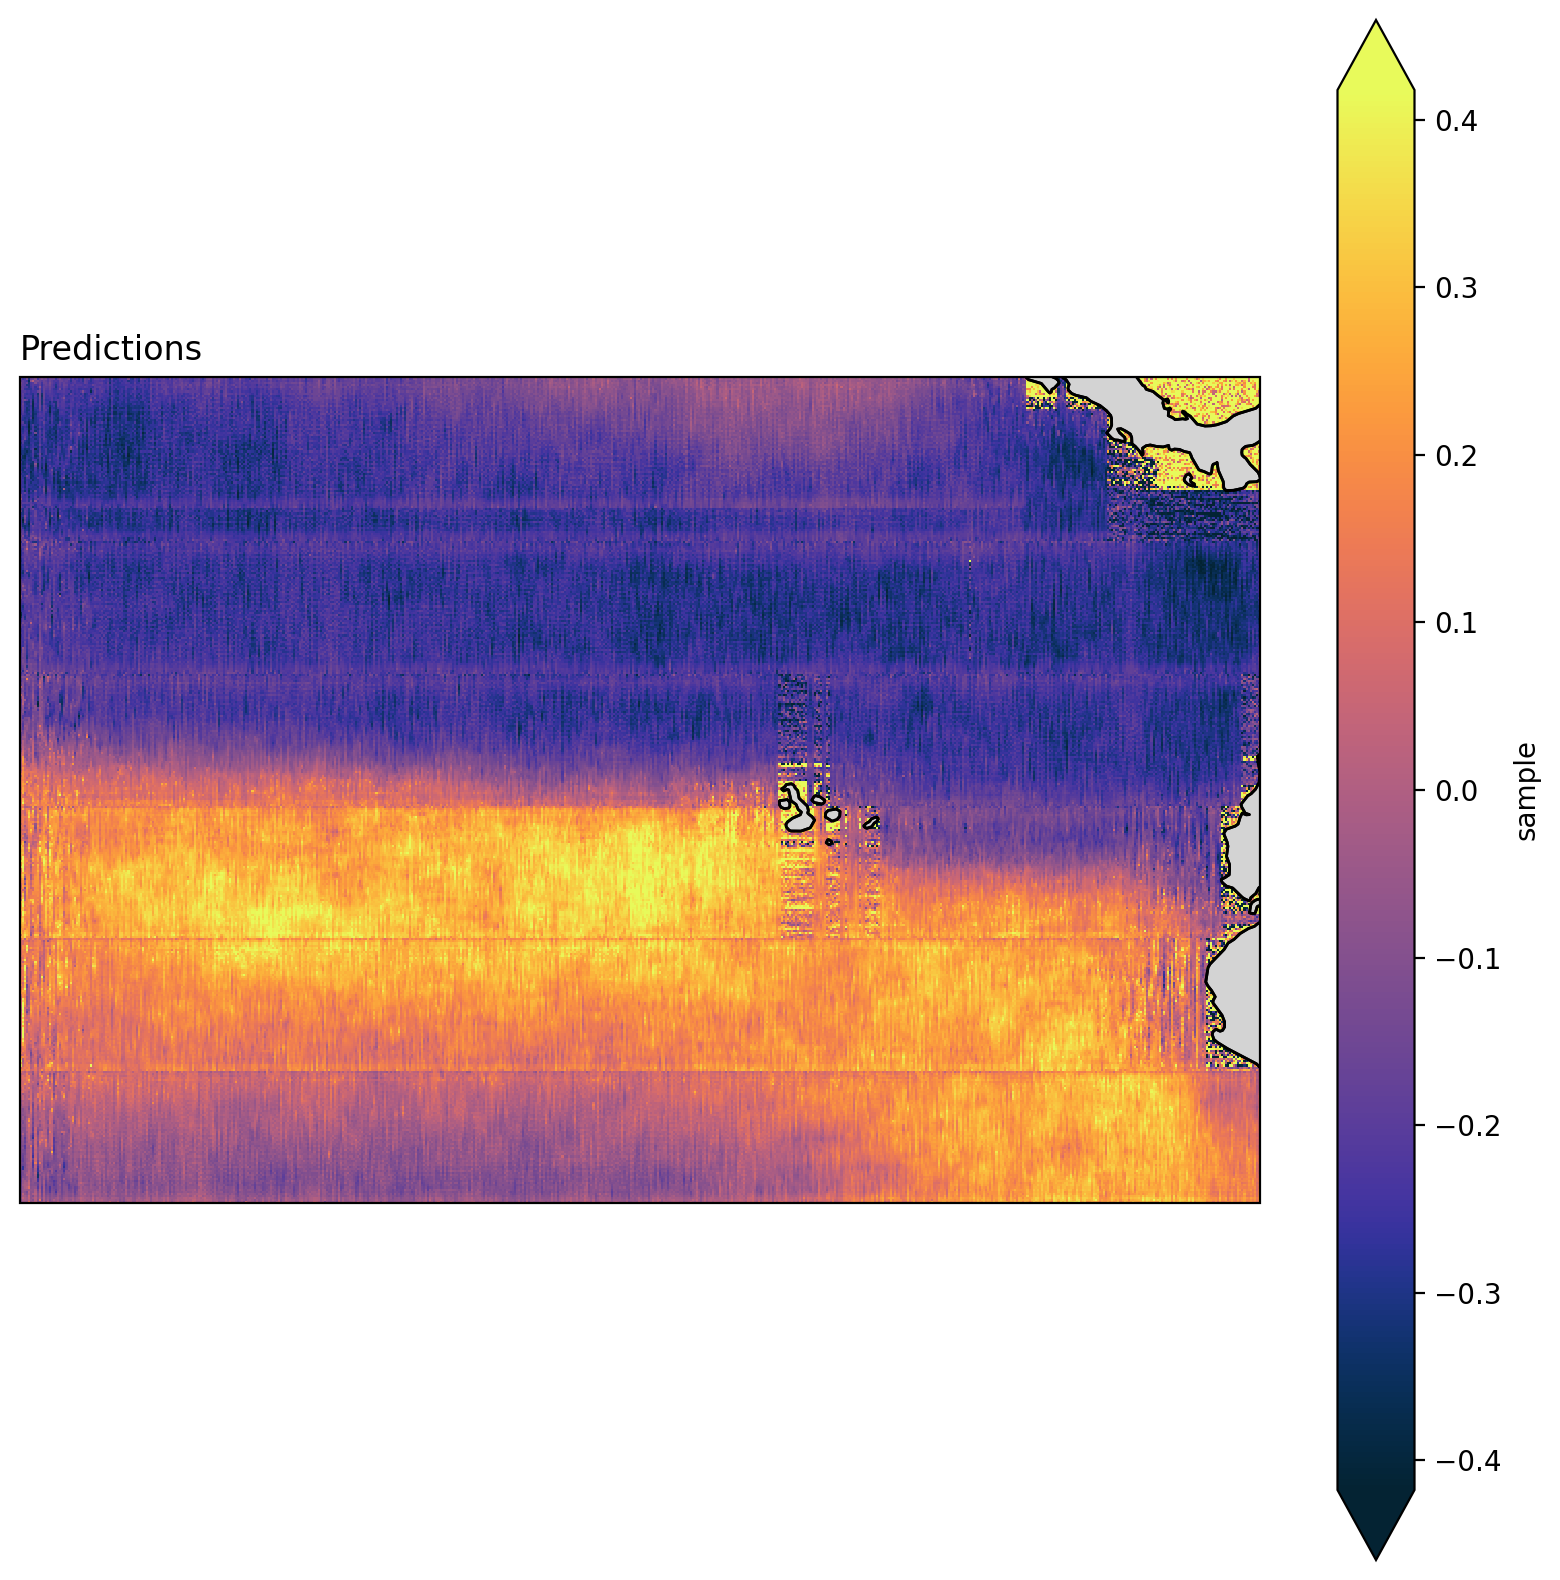

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm as cmo  # registers the cmocean colormaps to matplotlib
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# ax.set_global()
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgrey')
ax.add_feature(cfeature.COASTLINE, zorder=2, edgecolor='black')

ax.set_title('Predictions', fontsize=12, loc='left')

sample_ds.sample.plot.imshow(cmap='cmo.thermal', 
                             ax=ax, 
                             add_colorbar=True, 
                             transform=ccrs.PlateCarree(), 
                             robust=True
                             )
plt.show()

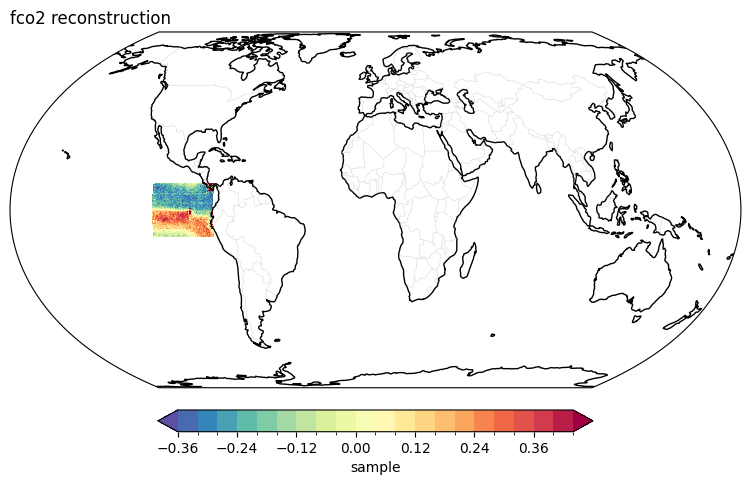

In [25]:
def plot_satmap(da): 
    fig, ax = plt.subplots(
    figsize=(9, 5), 
    subplot_kw=dict(
        projection=ccrs.EqualEarth()  # the map projection we want to use
    ), 
    dpi=100)

    img = (
        da
        .plot.imshow(  # the xarray.DataArray matplotlib API has [imshow, pcolormesh, contour, contourf] methods
            ax=ax,  # plot on the axis we created
            transform=ccrs.PlateCarree(),  # required to transform the data to the map projection (always PlateCarree)
            cmap='Spectral_r',
            levels=20,  # create discrete colorbar (not the same as contourf)
            center=False,  # if true, the colormap is centered on zero
            cbar_kwargs=dict(  # colorbar keyword arguments
                # label='Custom label for SLA [m]',  # we can set the label, but by default will use `da.attrs.long_name [da.attrs.units]` 
                location='bottom', 
                shrink=0.5,  # reduce the colorbar size to fit our plot
                pad=0.05),
            robust=True,  # this will set the colormap limits to the 2nd and 98th percentiles
        )
    )
    
    ax.coastlines(lw=1)  # axes with cartopy projection have a coastlines method
    ax.add_feature(cfeature.BORDERS.with_scale('110m'), edgecolor='0.8', linewidth=0.3)
    ax.set_title(f'fco2 reconstruction', loc='left', fontsize=12)
    
    fig.tight_layout()
    plt.show()

plot_satmap(sample_ds.sample)

In [109]:
dss = get_day_dataset(date)

All files reachable for date 2022-10-04 00:00:00
globcolour data already exists at ../data/inference/gridded_2022-10-04/globcolour.nc
soda data already exists at ../data/inference/gridded_2022-10-04/soda.nc
cmems data already exists at ../data/inference/gridded_2022-10-04/cmems.nc
sss_cci data already exists at ../data/inference/gridded_2022-10-04/sss_cci.nc
sss_multiobs data already exists at ../data/inference/gridded_2022-10-04/sss_multiobs.nc
sst_cci data already exists at ../data/inference/gridded_2022-10-04/sst_cci.nc
Reading globcolour data from ../data/inference/gridded_2022-10-04/globcolour.nc
Reading soda data from ../data/inference/gridded_2022-10-04/soda.nc
Reading cmems data from ../data/inference/gridded_2022-10-04/cmems.nc
Reading sss_cci data from ../data/inference/gridded_2022-10-04/sss_cci.nc
Reading sss_multiobs data from ../data/inference/gridded_2022-10-04/sss_multiobs.nc
Reading sst_cci data from ../data/inference/gridded_2022-10-04/sst_cci.nc


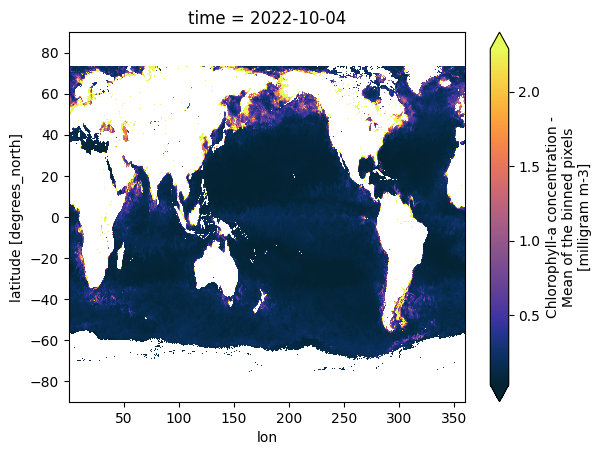

In [110]:
dss['globcolour'].chl_globcolour.sel(time=date, method='nearest').plot.imshow(cmap='cmo.thermal', robust=True)

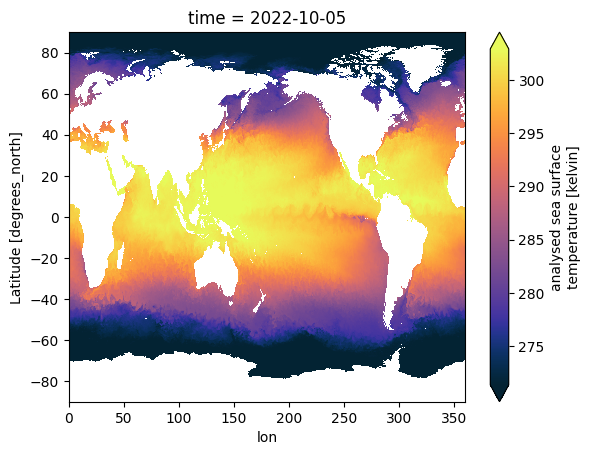

In [ ]:
dss['sst_cci'].sst_cci.sel(time=date, method='nearest').plot.imshow(cmap='cmo.thermal', robust=True)